## Testing a variety of statistics on a common shared distribution across the existing schema (FDMC) and the ingest data (FNMA)

In [ ]:
## If Running in google colab
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
! ls /content/drive/MyDrive/CSE\ 215

 Aurora_Evaluation.gdoc			       FPDB_evaluation.gdoc
 Azure_evaluation.gdoc			       JOB_evaluation.gdoc
 Bao_evaluation.gdoc			       many_to_one_cats_testing.ipynb
 BAO_Slides.gslides			       model_addition_testing.ipynb
 Data_Tamer_evaluation.gdoc		      'Project Proposal.gdoc'
 DeltaLake_evaluation.gdoc		       RocksDB_evaluation.gdoc
 display.csv				       scale_testing.ipynb
 display.gsheet				       scale_variance_take_two.ipynb
 Distributed_CC_Evaluation.gdoc		       scale_variance_testing.ipynb
 distribution_drift_testing.ipynb	       Snowflake_Evaluation.gdoc
 distribution_drift_testing_old.ipynb	       Spark_evaluation.gdoc
 Eliminating_Unscalable_Coms_evaluation.gdoc   stats_testing.ipynb
 F2FS_evaluation.gdoc			       testing_notebook.ipynb
 FalconDB_evaluation.gdoc		      'Untitled presentation.gslides'
 fdmc_subset.csv			      'Untitled spreadsheet.gsheet'
 file_layout.xlsx			       WBL_evaluation.gdoc
 fnma_subset.csv


In [ ]:
!cp /content/drive/MyDrive/CSE\ 215/fdmc_subset.csv .
!cp /content/drive/MyDrive/CSE\ 215/fnma_subset.csv .

In [ ]:
import numpy as np
import pandas as pd


fdmc = pd.read_csv('fdmc_subset.csv').drop(['Unnamed: 0', 'id_loan'], axis=1)
fnma = pd.read_csv('fnma_subset.csv').drop('Unnamed: 0', axis=1)

## Postal code is Zip 3 for both datasets-- freddie zero-fills theirs
fdmc['POSTAL CODE'] = [int(str(val)[:3]) for val in fdmc['POSTAL CODE']]
fdmc['CREDIT SCORE'].loc[fdmc.index[fdmc['CREDIT SCORE'] == 9999]] = np.nan



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Identify Categorical Features, Numeric Features and Unusable Features

In [ ]:
import string

LETTERS = string.ascii_letters

potential_cats_fdmc = []
potential_numeric_fdmc = []
nonunique_fdmc = []
for col in fdmc:
    has_letters = False
    letter_count = 0
    for val in fdmc[col]:
        if any([char in LETTERS for char in str(val)]):
            letter_count +=1 
    if letter_count > 0.95*fdmc.shape[0]:
        has_letters = True
    if len(fdmc[col].unique()) == 1:
        nonunique_fdmc.append(col)
        continue
    if has_letters or len(fdmc[col].unique())<10:
        potential_cats_fdmc.append(col)
    else:
        potential_numeric_fdmc.append(col)
fdmc_numeric = potential_numeric_fdmc
fdmc_cats = potential_cats_fdmc
print('FDMC Categorical')
print(potential_cats_fdmc)
print('FDMC Numeric')
print(potential_numeric_fdmc)
print('FDMC Nonunique')
print(nonunique_fdmc)


FDMC Categorical
['FIRST_PAYMENT_DATE', 'FIRST_TIME_HOMEBUYER_FLAG', 'MI_PERCENTAGE', 'NUMBER_OF_UNITS', 'OCCUPANCY_STATUS', 'CHANNEL', 'STATE', 'PROPERTY TYPE', 'LOAN_PURPOSE', 'NUMBER_BORROWERS', 'SELLER NAME', 'Servicer_Name', 'SUPER CONFORMING FLAG', 'PROGRAM INDICATOR', 'PROPERTY_VALUATION_METHOD']
FDMC Numeric
['CREDIT SCORE', 'MATURITY_DATE', 'MSA_CODE', 'ORIGINAL_CLTV', 'DTI', 'ORIGINAL_UPB', 'ORIGINAL_LTV', 'ORIGINAL_INTEREST_RATE', 'POSTAL CODE', 'ORIGINAL_LOAN_TERM']
FDMC Nonunique
['PPM_FLAG', 'Amortization_type', 'LSN', 'HARP_INDICATOR', 'IO_INDICATOR']


In [ ]:
potential_cats_fnma = []
potential_numeric_fnma = []
nonunique_fnma = []
for col in fnma:
    has_letters = False
    letter_count = 0
    for val in fnma[col]:
        if any([char in LETTERS for char in str(val)]):
            letter_count +=1 
    if letter_count > 0.95*fnma.shape[0]:
        has_letters = True
    if len(fnma[col].unique()) == 1:
        nonunique_fnma.append(col)
        continue
    if has_letters or len(fnma[col].unique())<10:
        potential_cats_fnma.append(col)
    else:
        potential_numeric_fnma.append(col)
fnma_numeric = potential_numeric_fnma
fnma_cats = potential_cats_fnma
print('FNMA Categorical')
print(potential_cats_fnma)
print('FNMA Numeric')
print(potential_numeric_fnma)
print('FNMA Nonunique')
print(nonunique_fnma)


FNMA Categorical
['Monthly Reporting Period', 'Channel', 'Seller Name', 'Servicer Name', 'First Payment Date', 'Number of Borrowers', 'First Time Home Buyer Indicator', 'Loan Purpose', 'Property Type', 'Number of Units', 'Occupancy Status', 'Property State', 'Mortgage Insurance Percentage', 'Current Loan Delinquency Status', 'Loan Payment History', 'Modification Flag', 'Zero Balance Code', 'Zero Balance Effective Date', 'UPB at the Time of Removal', 'Mortgage Insurance Type', 'Servicing Activity Indicator', 'HomeReady® Program Indicator', 'Relocation Mortgage Indicator', 'Property Valuation Method', 'High Balance Loan Indicator', 'Borrower Assistance Plan', 'Alternative Delinquency Resolution']
FNMA Numeric
['Loan Identifier', 'Original Interest Rate', 'Current Interest Rate', 'Original UPB', 'Current Actual UPB', 'Original Loan Term', 'Origination Date', 'Loan Age', 'Remaining Months to Legal Maturity', 'Remaining Months To Maturity', 'Maturity Date', 'Original Loan to Value Ratio (LT

## Define proper matching list


In [ ]:
match_list = {
    'FIRST_PAYMENT_DATE':'First Payment Date', 
    'FIRST_TIME_HOMEBUYER_FLAG':'First Time Home Buyer Indicator', 
    'MI_PERCENTAGE':'Mortgage Insurance Percentage', 
    'NUMBER_OF_UNITS':'Number of Units', 
    'OCCUPANCY_STATUS':'Occupancy Status', 
    'CHANNEL':'Channel', 
    'STATE':'Property State', 
    'PROPERTY TYPE':'Property Type',
    'LOAN_PURPOSE':'Loan Purpose', 
    'NUMBER_BORROWERS':'Number of Borrowers', 
    'SELLER NAME':'Seller Name', 
    'Servicer_Name':'Servicer Name', 
    'SUPER CONFORMING FLAG':'High Balance Loan Indicator', 
    'PROGRAM INDICATOR':'HomeReady® Program Indicator', 
    'PROPERTY_VALUATION_METHOD':'Property Valuation Method',
    'CREDIT SCORE':'Borrower Credit Score at Origination',
    'MATURITY_DATE':'Maturity Date', 
    'MSA_CODE':'Metropolitan Statistical Area (MSA)', 
    'ORIGINAL_CLTV':'Original Combined Loan to Value Ratio\n(CLTV)', 
    'DTI':'Debt-To-Income (DTI)', 
    'ORIGINAL_UPB':'Original UPB', 
    'ORIGINAL_LTV':'Original Loan to Value Ratio (LTV)', 
    'ORIGINAL_INTEREST_RATE':'Original Interest Rate', 
    'POSTAL CODE':'Zip Code Short', 
    'ORIGINAL_LOAN_TERM':'Original Loan Term'
}


# Testing without Normalizatiton

In [ ]:
# Define unique null placeholder for schema that doesn't interfere with known columns
# rank-standardize categorical features
import copy 
from scipy import stats

fdmc_copy = copy.deepcopy(fdmc)
for col in potential_numeric_fdmc:
    fdmc_copy[col] = fdmc_copy[col].fillna(np.mean(fdmc_copy[col]))

fnma_copy = copy.deepcopy(fnma)
for col in potential_numeric_fnma:
    fnma_copy[col] = fnma_copy[col].fillna(np.mean(fnma_copy[col]))

def standardize_labels(col):
    col = copy.deepcopy(col)
    value_counts = col.value_counts(dropna = False)
    for i in range(len(value_counts)):
        if str(value_counts.index[i]) == 'nan':
            col.loc[col.isnull()] = i+1
        else:
            col.loc[col == value_counts.index[i]] = i+1
    return col

for col in potential_cats_fdmc:
    fdmc_copy[col] = standardize_labels(fdmc_copy[col])

for col in potential_cats_fnma:
    fnma_copy[col] = standardize_labels(fnma_copy[col])



### T Test

In [ ]:
from scipy.stats import ttest_ind

col_match_tt_num = {}

unmatchable = []
for col1 in fdmc_copy[fdmc_numeric]:
    cols = []
    p_vals = []
    for col2 in fnma_copy[fnma_numeric]:
        try:
            t_test = ttest_ind(fdmc_copy[col1].sort_values(), fnma_copy[col2].sort_values(), nan_policy='omit')
            p_vals.append(t_test.pvalue)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(p_vals).argsort()[-3:][::-1]
    col_match_tt_num[col1] = [[cols[i] for i in ind], [p_vals[i] for i in ind]]

col_match_tt_num

{'CREDIT SCORE': [['Borrower Credit Score at Origination',
   'Total Principal Current',
   'Co-Borrower Credit Score at Origination'],
  [5.3076723952023864e-09, 2.4503976667632104e-26, 8.889728293715943e-127]],
 'DTI': [['Debt-To-Income (DTI)',
   'Total Principal Current',
   'Remaining Months to Legal Maturity'],
  [1.026336797078319e-12, 2.0242712270438718e-67, 0.0]],
 'MATURITY_DATE': [['Total Principal Current',
   'Remaining Months to Legal Maturity',
   'Original Interest Rate'],
  [0.0, 0.0, 0.0]],
 'MSA_CODE': [['Metropolitan Statistical Area (MSA)',
   'Total Principal Current',
   'Remaining Months to Legal Maturity'],
  [7.257715817912814e-144, 0.0, 0.0]],
 'ORIGINAL_CLTV': [['Original Loan to Value Ratio (LTV)',
   'Original Combined Loan to Value Ratio\n(CLTV)',
   'Total Principal Current'],
  [1.3122548285662572e-11, 1.2786761699773382e-16, 6.441613266899912e-65]],
 'ORIGINAL_INTEREST_RATE': [['Total Principal Current',
   'Original Interest Rate',
   'Current Interes

In [ ]:
num_right = 0

for val in col_match_tt_num.keys():
    col_match_names = col_match_tt_num[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1
TT_corr_num = num_right / (len(col_match_tt_num.keys()))

print('T-test % correct numeric = {}'.format(TT_corr_num))



T-test % correct numeric = 0.6


In [ ]:
col_match_tt_cat = {}

unmatchable = []
for col1 in fdmc_copy[fdmc_cats]:
    cols = []
    p_vals = []
    for col2 in fnma_copy[fnma_cats]:
        try:
            t_test = ttest_ind(fdmc_copy[col1].sort_values(), fnma_copy[col2].sort_values(), nan_policy='omit')
            p_vals.append(t_test.pvalue)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(p_vals).argsort()[-3:][::-1]
    col_match_tt_cat[col1] = [[cols[i] for i in ind], [p_vals[i] for i in ind]]

col_match_tt_cat


{'CHANNEL': [['Mortgage Insurance Percentage',
   'First Payment Date',
   'Property Type'],
  [0.329801169102499, 0.00014887280116059664, 2.6452717618608875e-14]],
 'FIRST_PAYMENT_DATE': [['Seller Name',
   'Current Loan Delinquency Status',
   'Mortgage Insurance Percentage'],
  [5.4915995086931815e-219, 1.2234098790358343e-291, 0.0]],
 'FIRST_TIME_HOMEBUYER_FLAG': [['UPB at the Time of Removal',
   'Occupancy Status',
   'First Time Home Buyer Indicator'],
  [5.689158762357106e-35, 4.182105804984573e-68, 6.596918294190172e-175]],
 'LOAN_PURPOSE': [['Loan Purpose',
   'Mortgage Insurance Percentage',
   'First Payment Date'],
  [0.001257329405682551, 2.3492904090745193e-144, 1.0164371351018697e-151]],
 'MI_PERCENTAGE': [['Channel',
   'Number of Borrowers',
   'Property Valuation Method'],
  [0.03887543851851836, 1.8912018240122867e-18, 3.4778300284956093e-23]],
 'NUMBER_BORROWERS': [['Property Type',
   'Number of Borrowers',
   'Mortgage Insurance Percentage'],
  [0.046582777096162

In [ ]:
num_right = 0

for val in col_match_tt_cat.keys():
    col_match_names = col_match_tt_cat[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1
TT_corr_cat = num_right / (len(col_match_tt_cat.keys()))

print('T-test % correct categorical = {}'.format(TT_corr_cat))


T-test % correct categorical = 0.2


### MDL

In [ ]:
def jaccard(set1, set2):
    intersection = len(list(set1.intersection(set2)))
    union = (len(list(set1)) + len(list(set2))) - intersection
    return float(intersection) / union

col_match_MDL_cat = {}

set_dict_fdmc_cat = {}
for col in fdmc_cats:
    set_dict_fdmc_cat[col] = set(fdmc[col])
set_dict_fnma_cat = {}
for col in fnma_cats:
    set_dict_fnma_cat[col] = set(fnma[col])

unmatchable = []
for col1 in fdmc_cats:
    cols = []
    MDL_vals = []
    for col2 in fnma_cats:
        try:
            mdl_sim = jaccard(set_dict_fdmc_cat[col1], set_dict_fnma_cat[col2])
            MDL_vals.append(mdl_sim)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(MDL_vals).argsort()[-3:][::-1]
    col_match_MDL_cat[col1] = [[cols[i] for i in ind], [MDL_vals[i] for i in ind]]

col_match_MDL_cat

{'CHANNEL': [['Channel', 'Loan Purpose', 'Alternative Delinquency Resolution'],
  [1.0, 0.5, 0.0]],
 'FIRST_PAYMENT_DATE': [['Alternative Delinquency Resolution',
   'Mortgage Insurance Percentage',
   'Channel'],
  [0.0, 0.0, 0.0]],
 'FIRST_TIME_HOMEBUYER_FLAG': [['High Balance Loan Indicator',
   'Relocation Mortgage Indicator',
   'HomeReady® Program Indicator'],
  [1.0, 1.0, 1.0]],
 'LOAN_PURPOSE': [['Loan Purpose',
   'Alternative Delinquency Resolution',
   'Modification Flag'],
  [0.5, 0.25, 0.25]],
 'MI_PERCENTAGE': [['Current Loan Delinquency Status',
   'Mortgage Insurance Percentage',
   'Channel'],
  [0.1, 0.0003795066413662239, 0.0]],
 'NUMBER_BORROWERS': [['Number of Borrowers',
   'Number of Units',
   'Current Loan Delinquency Status'],
  [1.0, 1.0, 0.4]],
 'NUMBER_OF_UNITS': [['Number of Borrowers',
   'Number of Units',
   'Current Loan Delinquency Status'],
  [1.0, 1.0, 0.4]],
 'OCCUPANCY_STATUS': [['Occupancy Status',
   'Loan Purpose',
   'Alternative Delinquency R

In [ ]:
num_right = 0

for val in col_match_MDL_cat.keys():
    col_match_names = col_match_MDL_cat[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1
MDL_corr_cat = num_right / (len(col_match_MDL_cat.keys()))

print('MDL-test % correct categorical = {}'.format(MDL_corr_cat))

MDL-test % correct categorical = 0.4


In [ ]:
col_match_MDL_num = {}

set_dict_fdmc_num = {}
for col in fdmc_numeric:
    set_dict_fdmc_num[col] = set(fdmc[col])
set_dict_fnma_num = {}
for col in fnma_numeric:
    set_dict_fnma_num[col] = set(fnma[col])

unmatchable = []
for col1 in fdmc_numeric:
    cols = []
    MDL_vals = []
    for col2 in fnma_numeric:
        try:
            mdl_sim = jaccard(set_dict_fdmc_num[col1], set_dict_fnma_num[col2])
            MDL_vals.append(mdl_sim)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(MDL_vals).argsort()[-3:][::-1]
    col_match_MDL_num[col1] = [[cols[i] for i in ind], [MDL_vals[i] for i in ind]]
    
col_match_MDL_num


{'CREDIT SCORE': [['Borrower Credit Score at Origination',
   'Zip Code Short',
   'Co-Borrower Credit Score at Origination'],
  [0.8846153846153846, 0.18411552346570398, 0.014650692840646651]],
 'DTI': [['Debt-To-Income (DTI)',
   'Original Loan to Value Ratio (LTV)',
   'Original Combined Loan to Value Ratio\n(CLTV)'],
  [0.8275862068965517, 0.4329896907216495, 0.4]],
 'MATURITY_DATE': [['Total Principal Current',
   'Remaining Months to Legal Maturity',
   'Original Interest Rate'],
  [0.0, 0.0, 0.0]],
 'MSA_CODE': [['Metropolitan Statistical Area (MSA)',
   'Origination Date',
   'Total Principal Current'],
  [0.14314354450681635, 0.0004012841091492777, 0.0]],
 'ORIGINAL_CLTV': [['Original Combined Loan to Value Ratio\n(CLTV)',
   'Original Loan to Value Ratio (LTV)',
   'Debt-To-Income (DTI)'],
  [0.9509803921568627, 0.8725490196078431, 0.49056603773584906]],
 'ORIGINAL_INTEREST_RATE': [['Original Interest Rate',
   'Current Interest Rate',
   'Loan Age'],
  [0.23861566484517305, 

In [ ]:
num_right = 0

for val in col_match_MDL_num.keys():
    col_match_names = col_match_MDL_num[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1
MDL_corr_num = num_right / (len(col_match_MDL_num.keys()))

print('MDL-test % correct numeric = {}'.format(MDL_corr_num))


MDL-test % correct numeric = 0.8


### KL

In [ ]:
import sklearn
from scipy.special import softmax
def KL(a, b, buckettype, buckets):
    if buckettype is None:
        print('Choose a bucket type from "bins" or "quantiles"')
        return False

    def scale_range (input, min, max):
        input += -(np.min(input))
        input /= np.max(input) / (max - min)
        input += min
        return input

    breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

    if buckettype == 'bins':
        breakpoints_a = scale_range(breakpoints, np.min(a), np.max(a))
    elif buckettype == 'quantiles':
        breakpoints = np.stack([np.percentile(a, b) for b in breakpoints])

    expected_percents = np.histogram(a, breakpoints)[0] / len(a)
    actual_percents = np.histogram(b, breakpoints)[0] / len(b)
    
    a = np.asarray(expected_percents, dtype=np.float)
    b = np.asarray(actual_percents, dtype=np.float)
    def sub_kl(perc):
        if perc == 0:
            return 0.0001
        return perc
    for i, val in enumerate(a):
        a[i] = sub_kl(a[i])
    for i, val in enumerate(b):
        b[i] = sub_kl(b[i])
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

col_match_KL_num = {}

unmatchable = []
for col1 in fdmc_copy[fdmc_numeric]:
    cols = []
    KL_vals = []
    buckets = 20
    for col2 in fnma_copy[fnma_numeric]:
        try:
            kl_div = KL(fdmc_copy[col1].sort_values(), fnma_copy[col2].sort_values(), buckettype='bins', buckets= buckets)
            KL_vals.append(kl_div)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(KL_vals).argsort()[:3]
    col_match_KL_num[col1] = [[cols[i] for i in ind], [KL_vals[i] for i in ind]]
col_match_KL_num

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


{'CREDIT SCORE': [['Borrower Credit Score at Origination',
   'Co-Borrower Credit Score at Origination',
   'Zip Code Short'],
  [0.007972534369193828, 0.5828573773977983, 2.050704866696581]],
 'DTI': [['Debt-To-Income (DTI)',
   'Original Loan to Value Ratio (LTV)',
   'Original Combined Loan to Value Ratio\n(CLTV)'],
  [0.00656568892532745, 1.915238101898016, 1.9334011469419667]],
 'MATURITY_DATE': [['Original UPB', 'Current Actual UPB', 'Loan Identifier'],
  [6.043923389508734, 6.184578899956262, 8.325166361766453]],
 'MSA_CODE': [['Metropolitan Statistical Area (MSA)',
   'Origination Date',
   'Maturity Date'],
  [0.14890264475142473, 5.712951009902176, 5.721006171366975]],
 'ORIGINAL_CLTV': [['Original Combined Loan to Value Ratio\n(CLTV)',
   'Original Loan to Value Ratio (LTV)',
   'Zip Code Short'],
  [0.028520145836884083, 0.02932828042678362, 3.6734456707413585]],
 'ORIGINAL_INTEREST_RATE': [['Current Interest Rate',
   'Original Interest Rate',
   'Loan Age'],
  [0.07505908

In [ ]:
num_right = 0

for val in col_match_KL_num.keys():
    col_match_names = col_match_KL_num[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1
KL_corr_num = num_right / (len(col_match_KL_num.keys()))

print('KL-div % correct numeric = {}'.format(KL_corr_num))


KL-div % correct numeric = 0.8


In [ ]:
col_match_KL_cat = {}

unmatchable = []
for col1 in fdmc_copy[fdmc_cats]:
    cols = []
    KL_vals = []
    buckets = 20
    for col2 in fnma_copy[fnma_cats]:
        try:
            kl_div = KL(fdmc_copy[col1].sort_values(), fnma_copy[col2].sort_values(), buckettype='bins', buckets= buckets)
            KL_vals.append(kl_div)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(KL_vals).argsort()[:3]
    col_match_KL_cat[col1] = [[cols[i] for i in ind], [KL_vals[i] for i in ind]]
col_match_KL_cat


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


{'CHANNEL': [['Property Type', 'Channel', 'First Payment Date'],
  [0.02327428283048507, 0.02925664703833753, 0.05098322439796782]],
 'FIRST_PAYMENT_DATE': [['Seller Name', 'Servicer Name', 'Property State'],
  [0.670142206573913, 0.6948217332781159, 1.011461655868271]],
 'FIRST_TIME_HOMEBUYER_FLAG': [['First Time Home Buyer Indicator',
   'HomeReady® Program Indicator',
   'High Balance Loan Indicator'],
  [0.02983054945721604, 0.04322313977551681, 0.06913585239658669]],
 'LOAN_PURPOSE': [['Loan Purpose',
   'Monthly Reporting Period',
   'Loan Payment History'],
  [0.003501638093474646, 0.03774352278281699, 0.04655536215735935]],
 'MI_PERCENTAGE': [['Mortgage Insurance Percentage',
   'First Payment Date',
   'Property Type'],
  [0.034224813197775955, 0.10005212506800304, 0.17149992410762988]],
 'NUMBER_BORROWERS': [['Number of Borrowers',
   'Property Valuation Method',
   'Property Type'],
  [0.001025612596227642, 0.06037310370625343, 0.13521565817308662]],
 'NUMBER_OF_UNITS': [['N

In [ ]:
num_right = 0

for val in col_match_KL_cat.keys():
    col_match_names = col_match_KL_cat[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1
KL_corr_cat = num_right / (len(col_match_KL_cat.keys()))

print('KL-div % correct numeric = {}'.format(KL_corr_cat))

KL-div % correct numeric = 0.6666666666666666


### KS

In [ ]:
from scipy.stats import ks_2samp

col_match_KS_num = {}

unmatchable = []
for col1 in fdmc_copy[fdmc_numeric]:
    cols = []
    KS_vals = []
    for col2 in fnma_copy[fnma_numeric]:
        try:
            KS = ks_2samp(fdmc_copy[col1].sort_values(), fnma_copy[col2].sort_values()).pvalue
            KS_vals.append(KS)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(KS_vals).argsort()[-3:][::-1]
    col_match_KS_num[col1] = [[cols[i] for i in ind], [KS_vals[i] for i in ind]]
col_match_KS_num

{'CREDIT SCORE': [['Borrower Credit Score at Origination',
   'Total Principal Current',
   'Remaining Months to Legal Maturity'],
  [8.0750132131524505e-25, 0.0, 0.0]],
 'DTI': [['Debt-To-Income (DTI)',
   'Total Principal Current',
   'Remaining Months to Legal Maturity'],
  [7.363852280551629e-11, 0.0, 0.0]],
 'MATURITY_DATE': [['Total Principal Current',
   'Remaining Months to Legal Maturity',
   'Original Interest Rate'],
  [0.0, 0.0, 0.0]],
 'MSA_CODE': [['Metropolitan Statistical Area (MSA)',
   'Total Principal Current',
   'Remaining Months to Legal Maturity'],
  [1.8782466558813358e-124, 0.0, 0.0]],
 'ORIGINAL_CLTV': [['Original Loan to Value Ratio (LTV)',
   'Original Combined Loan to Value Ratio\n(CLTV)',
   'Total Principal Current'],
  [1.0661211018267644e-51, 5.737838515761774e-58, 0.0]],
 'ORIGINAL_INTEREST_RATE': [['Total Principal Current',
   'Remaining Months to Legal Maturity',
   'Original Interest Rate'],
  [0.0, 0.0, 0.0]],
 'ORIGINAL_LOAN_TERM': [['Original Lo

In [ ]:
num_right = 0

for val in col_match_KS_num.keys():
    col_match_names = col_match_KS_num[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1
KS_corr_num = num_right / (len(col_match_KS_num.keys()))

print('KS-test % correct numeric = {}'.format(KS_corr_num))


KS-test % correct numeric = 0.7


In [ ]:
col_match_KS_cat = {}

unmatchable = []
for col1 in fdmc_copy[fdmc_cats]:
    cols = []
    KS_vals = []
    for col2 in fnma_copy[fnma_cats]:
        try:
            KS = ks_2samp(fdmc_copy[col1].sort_values(), fnma_copy[col2].sort_values()).pvalue
            KS_vals.append(KS)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(KS_vals).argsort()[-3:][::-1]
    col_match_KS_cat[col1] = [[cols[i] for i in ind], [KS_vals[i] for i in ind]]

col_match_KS_cat


{'CHANNEL': [['Property Type', 'First Payment Date', 'Channel'],
  [1.3410101905590955e-11, 1.681773750711407e-20, 1.4301782456304764e-128]],
 'FIRST_PAYMENT_DATE': [['Alternative Delinquency Resolution',
   'Mortgage Insurance Percentage',
   'Channel'],
  [0.0, 0.0, 0.0]],
 'FIRST_TIME_HOMEBUYER_FLAG': [['HomeReady® Program Indicator',
   'Occupancy Status',
   'High Balance Loan Indicator'],
  [1.9656006112462797e-61, 6.8687555432283415e-62, 4.7819814603338805e-84]],
 'LOAN_PURPOSE': [['Loan Purpose',
   'Monthly Reporting Period',
   'Loan Payment History'],
  [1.0030026093285692e-10, 1.5538700732548192e-177, 4.31422984969088e-179]],
 'MI_PERCENTAGE': [['Mortgage Insurance Percentage',
   'Channel',
   'First Time Home Buyer Indicator'],
  [3.420514233081782e-40, 6.758985973447278e-115, 2.5304026860423625e-175]],
 'NUMBER_BORROWERS': [['Number of Borrowers',
   'Property Type',
   'First Payment Date'],
  [8.526830644925734e-06, 2.535121520459051e-101, 5.297868995805085e-188]],
 'N

In [ ]:
num_right = 0

for val in col_match_KS_cat.keys():
    col_match_names = col_match_KS_cat[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1
KS_corr_cat = num_right / (len(col_match_KS_cat.keys()))

print('KS-test % correct categorical = {}'.format(KS_corr_cat))


KS-test % correct categorical = 0.6


### PSI

In [ ]:
def psi(input1, input2, buckets, buckettype = None):
    """
    input1: first column
    input2: second column
    buckets: # buckets
    """
    if buckettype is None:
        print('Choose a bucket type from "bins" or "quantiles"')
        return False

    def scale_range (input, min, max):
        input += -(np.min(input))
        input /= np.max(input) / (max - min)
        input += min
        return input

    breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

    if buckettype == 'bins':
        breakpoints = scale_range(breakpoints, np.min(input1), np.max(input1))
    elif buckettype == 'quantiles':
        breakpoints = np.stack([np.percentile(input1, b) for b in breakpoints])

    expected_percents = np.histogram(input1, breakpoints)[0] / len(input1)
    actual_percents = np.histogram(input2, breakpoints)[0] / len(input2)

    def sub_psi(e_perc, a_perc):
        '''Calculate the actual PSI value from comparing the values.
            Update the actual value to a very small number if equal to zero
        '''
        if a_perc == 0:
            a_perc = 0.0001
        if e_perc == 0:
            e_perc = 0.0001

        value = (e_perc - a_perc) * np.log(e_perc / a_perc)
        return(value)

    psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

    return(psi_value)

col_match_PSI_num = {}

unmatchable = []
for col1 in fdmc_copy[fdmc_numeric]:
    cols = []
    PSI_vals = []
    buckets = 20
    for col2 in fnma_copy[fnma_numeric]:
        try:
            PSI = psi(fdmc_copy[col1], fnma_copy[col2], buckets, buckettype = 'bins')
            PSI_vals.append(PSI)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(PSI_vals).argsort()[:3]
    col_match_PSI_num[col1] = [[cols[i] for i in ind], [PSI_vals[i] for i in ind]]

col_match_PSI_num

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


{'CREDIT SCORE': [['Borrower Credit Score at Origination',
   'Co-Borrower Credit Score at Origination',
   'Zip Code Short'],
  [0.016467588874195124, 1.3986830002871813, 1.8871427111087316]],
 'DTI': [['Debt-To-Income (DTI)',
   'Original Loan to Value Ratio (LTV)',
   'Original Combined Loan to Value Ratio\n(CLTV)'],
  [0.012212225262222303, 1.6410387037689578, 1.6606517959443643]],
 'MATURITY_DATE': [['Original UPB', 'Current Actual UPB', 'Loan Identifier'],
  [6.037786003310012, 6.178385464391676, 8.319723885068756]],
 'MSA_CODE': [['Metropolitan Statistical Area (MSA)',
   'Origination Date',
   'Maturity Date'],
  [0.1142049313267264, 5.666960973608552, 5.676131256511635]],
 'ORIGINAL_CLTV': [['Original Loan to Value Ratio (LTV)',
   'Original Combined Loan to Value Ratio\n(CLTV)',
   'Zip Code Short'],
  [0.05954183750562234, 0.06109592830271561, 3.5633303513557943]],
 'ORIGINAL_INTEREST_RATE': [['Current Interest Rate',
   'Original Interest Rate',
   'Loan Age'],
  [0.1527815

In [ ]:
num_right = 0

for val in col_match_PSI_num.keys():
    col_match_names = col_match_PSI_num[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1
PSI_corr_num = num_right / (len(col_match_PSI_num.keys()))

print('PSI-test % correct numeric = {}'.format(PSI_corr_num))

PSI-test % correct numeric = 0.6


In [ ]:
col_match_PSI_cat = {}

unmatchable = []
for col1 in fdmc_copy[fdmc_cats]:
    cols = []
    PSI_vals = []
    buckets = 20
    for col2 in fnma_copy[fnma_cats]:
        try:
            PSI = psi(fdmc_copy[col1], fnma_copy[col2], buckets, buckettype = 'bins')
            PSI_vals.append(PSI)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(PSI_vals).argsort()[:3]
    col_match_PSI_cat[col1] = [[cols[i] for i in ind], [PSI_vals[i] for i in ind]]

col_match_PSI_cat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


{'CHANNEL': [['Property Type', 'First Payment Date', 'Channel'],
  [0.020034273869328302, 0.02219043866727332, 0.056650445483285544]],
 'FIRST_PAYMENT_DATE': [['Servicer Name', 'Property State', 'Seller Name'],
  [0.8598570434492143, 0.8637223260648361, 0.9167854683607332]],
 'FIRST_TIME_HOMEBUYER_FLAG': [['Mortgage Insurance Percentage',
   'First Time Home Buyer Indicator',
   'Channel'],
  [0.02798486839512346, 0.06450889017248196, 0.06976671297815668]],
 'LOAN_PURPOSE': [['Loan Purpose',
   'Loan Payment History',
   'Monthly Reporting Period'],
  [0.0070727252385220755, 0.07109768492737088, 0.07490070203145671]],
 'MI_PERCENTAGE': [['Mortgage Insurance Percentage',
   'First Payment Date',
   'Property Type'],
  [0.07316885804376673, 0.23017590662371193, 0.3816036634344239]],
 'NUMBER_BORROWERS': [['Number of Borrowers',
   'Property Valuation Method',
   'First Time Home Buyer Indicator'],
  [0.002048503760974531, 0.10447482263926493, 0.32668894092385947]],
 'NUMBER_OF_UNITS': [[

In [ ]:
num_right = 0

for val in col_match_PSI_cat.keys():
    col_match_names = col_match_PSI_cat[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1
PSI_corr_cat = num_right / (len(col_match_PSI_cat.keys()))

print('PSI-test % correct categorical = {}'.format(PSI_corr_cat))


PSI-test % correct categorical = 0.6


### Voting Based System

In [ ]:
from scipy import stats
all_prediction_results = [col_match_tt_num, col_match_MDL_num, col_match_KL_num, col_match_KS_num, col_match_PSI_num]
num_correct = 0
for col in fdmc_numeric:
    all_preds = []
    for pred_dict in all_prediction_results:
        if col in pred_dict.keys():
            col_res = pred_dict[col]
            if col_res[1][0] != 0:
                    all_preds.append(col_res[0][0])
        else:
            continue
    if stats.mode(all_preds)[0] == match_list[col]:
        num_correct += 1

Vote_corr_num = num_correct/len(fdmc_numeric)
print('Voting-based accuracy numeric: {}'.format(Vote_corr_num))


Voting-based accuracy numeric: 0.7


In [ ]:
from scipy import stats
all_prediction_results = [col_match_tt_cat, col_match_MDL_cat, col_match_KL_cat, col_match_KS_cat, col_match_PSI_cat, col_match_PSI_num]
num_correct = 0
for col in fdmc_cats:
    all_preds = []
    for pred_dict in all_prediction_results:
        if col in pred_dict.keys():
            col_res = pred_dict[col]
            if col_res[1][0] != 0:
                    all_preds.append(col_res[0][0])
        else:
            continue
    if stats.mode(all_preds)[0] == match_list[col]:
        num_correct += 1

Vote_corr_cat = num_correct/len(match_list.keys())
print('Voting-based accuracy categorical: {}'.format(Vote_corr_cat))

Voting-based accuracy categorical: 0.4


## Examine Accuracies

(0.0, 1.0)

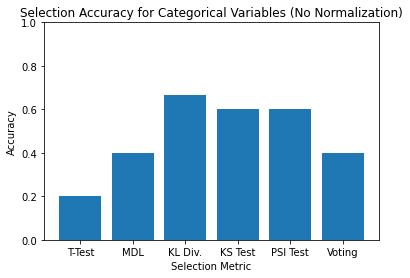

In [ ]:
accs = [TT_corr_cat, MDL_corr_cat, KL_corr_cat, KS_corr_cat, PSI_corr_cat, Vote_corr_cat]
types = ['T-Test', 'MDL', 'KL Div.', 'KS Test', 'PSI Test', 'Voting']

plt.figure()
plt.bar(types, accs)
plt.xlabel('Selection Metric')
plt.ylabel('Accuracy')
plt.title('Selection Accuracy for Categorical Variables (No Normalization)')
plt.ylim(0, 1)


(0.0, 1.0)

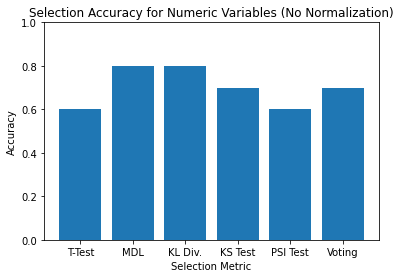

In [ ]:
accs = [TT_corr_num, MDL_corr_num, KL_corr_num, KS_corr_num, PSI_corr_num, Vote_corr_num]
types = ['T-Test', 'MDL', 'KL Div.', 'KS Test', 'PSI Test', 'Voting']

plt.figure()
plt.bar(types, accs)
plt.xlabel('Selection Metric')
plt.ylabel('Accuracy')
plt.title('Selection Accuracy for Numeric Variables (No Normalization)')
plt.ylim(0, 1)


### With Normalization


In [ ]:
# Normalize
from sklearn.preprocessing import MinMaxScaler

def normalize_numeric(col):
    col = np.asarray(col.copy()).reshape(-1, 1)
    scaler = MinMaxScaler()
    scaler.fit(col)
    col = scaler.transform(col)
    return col
for col in fdmc_numeric:
    fdmc_copy[col] = normalize_numeric(fdmc_copy[col])
for col in fnma_numeric:
    fnma_copy[col] = normalize_numeric(fnma_copy[col])


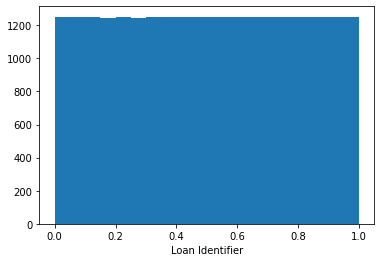

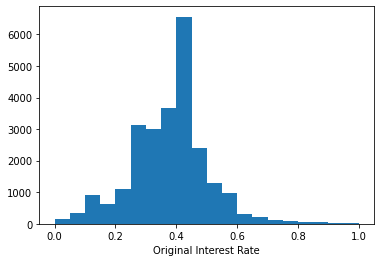

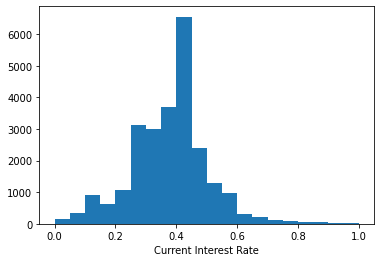

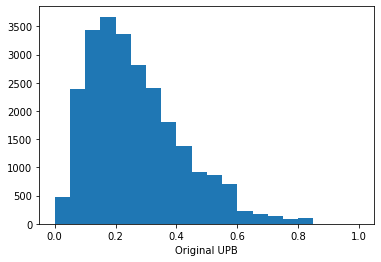

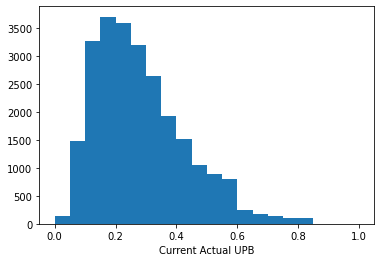

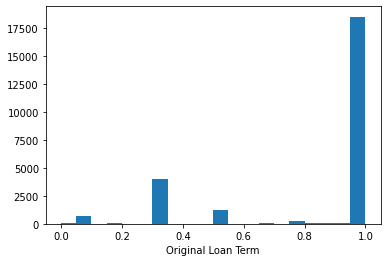

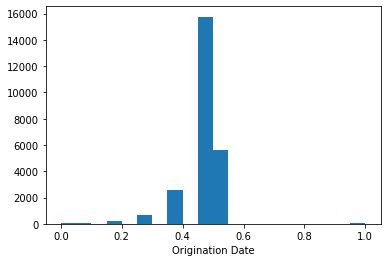

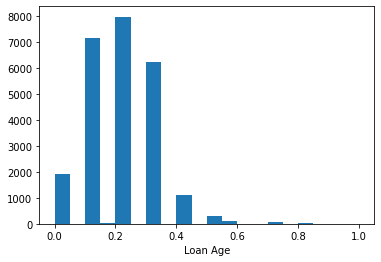

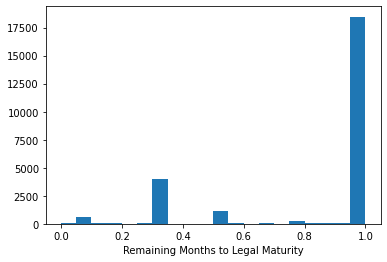

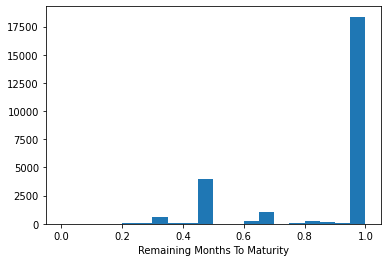

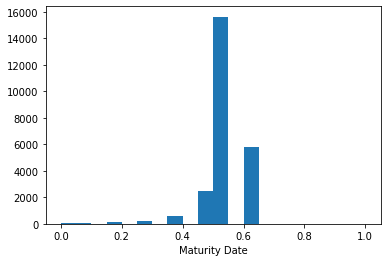

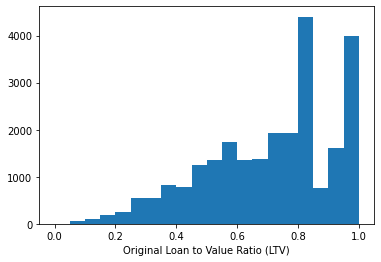

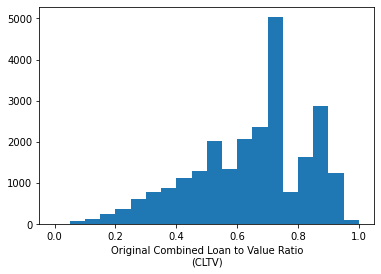

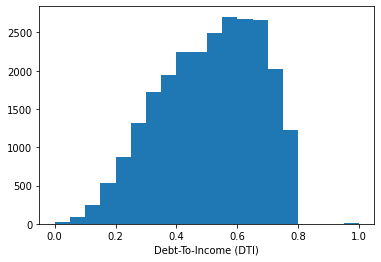

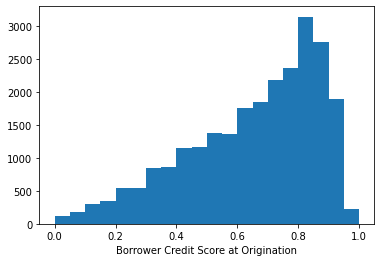

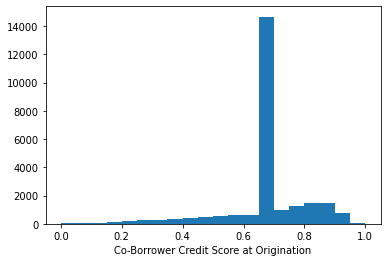

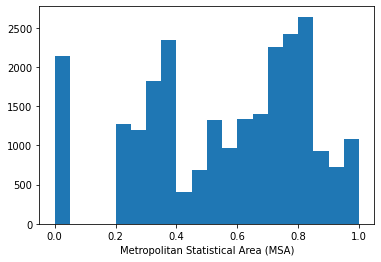

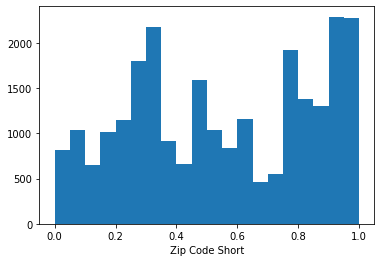

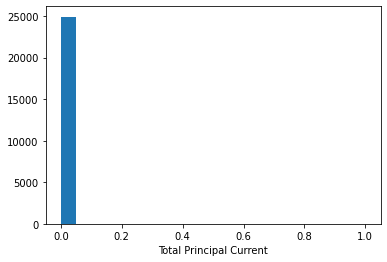

In [ ]:
import matplotlib.pyplot as plt
for col in fnma_numeric:
    plt.figure()
    plt.hist(fnma_copy[col], bins=20)
    plt.xlabel(col)
    plt.show()

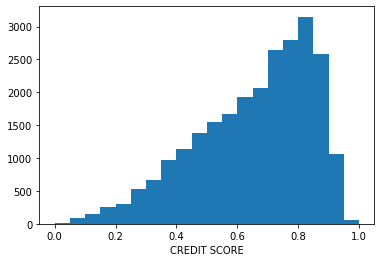

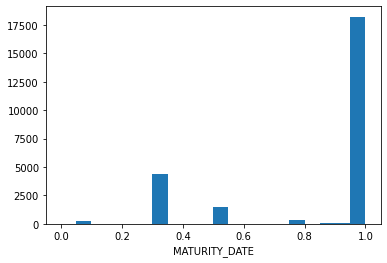

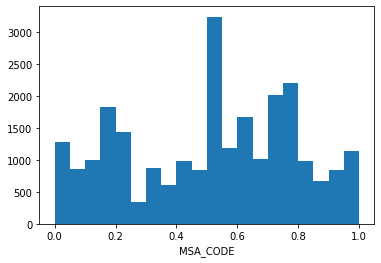

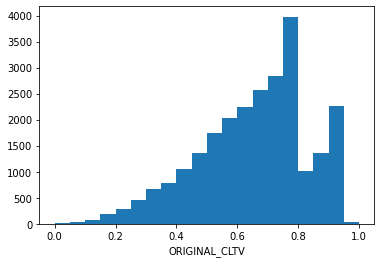

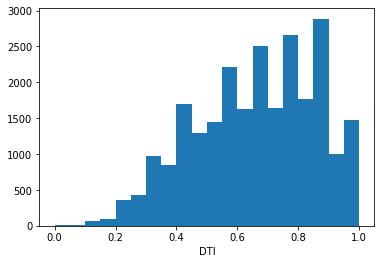

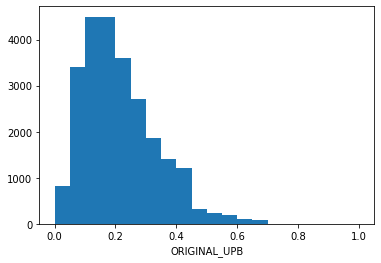

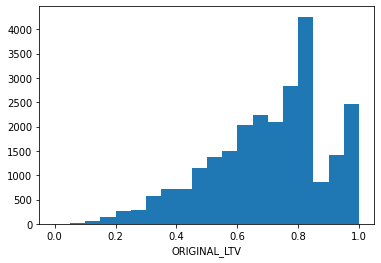

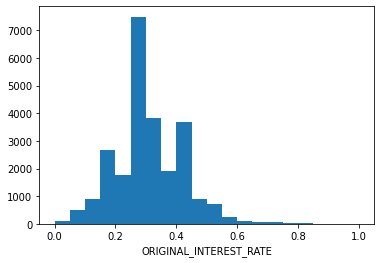

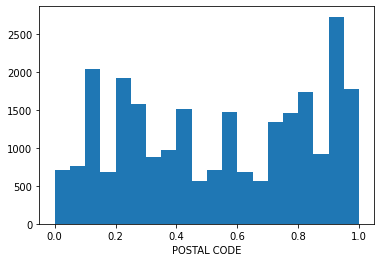

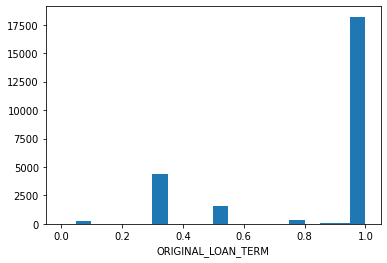

In [ ]:
import matplotlib.pyplot as plt
for col in fdmc_numeric:
    plt.figure()
    plt.hist(fdmc_copy[col], bins=20)
    plt.xlabel(col)
    plt.show()

### T Test

In [ ]:
col_match_tt_num = {}

unmatchable = []
for col1 in fdmc_copy[fdmc_numeric]:
    cols = []
    p_vals = []
    for col2 in fnma_copy[fnma_numeric]:
        try:
            t_test = ttest_ind(fdmc_copy[col1].sort_values(), fnma_copy[col2].sort_values(), nan_policy='omit')
            p_vals.append(t_test.pvalue)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(p_vals).argsort()[-3:][::-1]
    col_match_tt_num[col1] = [[cols[i] for i in ind], [p_vals[i] for i in ind]]

col_match_tt_num

{'CREDIT SCORE': [['Original Combined Loan to Value Ratio\n(CLTV)',
   'Borrower Credit Score at Origination',
   'Co-Borrower Credit Score at Origination'],
  [0.48299145253842624, 0.01566609595398763, 5.6346242386023435e-28]],
 'DTI': [['Original Combined Loan to Value Ratio\n(CLTV)',
   'Co-Borrower Credit Score at Origination',
   'Borrower Credit Score at Origination'],
  [2.165499809422424e-07, 4.1041504803655006e-08, 3.352826302958318e-11]],
 'MATURITY_DATE': [['Original Loan Term',
   'Remaining Months to Legal Maturity',
   'Remaining Months To Maturity'],
  [0.29493181788238576, 0.27801424011752235, 5.652380742865775e-60]],
 'MSA_CODE': [['Debt-To-Income (DTI)', 'Loan Identifier', 'Zip Code Short'],
  [0.04395260868337173, 9.093149410176156e-08, 1.2601460241241807e-45]],
 'ORIGINAL_CLTV': [['Borrower Credit Score at Origination',
   'Original Combined Loan to Value Ratio\n(CLTV)',
   'Co-Borrower Credit Score at Origination'],
  [0.048818395956722764, 5.6215846631662214e-05, 

In [ ]:
num_right = 0

for val in col_match_tt_num.keys():
    col_match_names = col_match_tt_num[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1

TT_corr_num = num_right / len(col_match_tt_num.keys())
print('T-test % correct numeric = {}'.format(TT_corr_num))

T-test % correct numeric = 0.3


In [ ]:
col_match_tt_cat = {}

unmatchable = []
for col1 in fdmc_copy[fdmc_cats]:
    cols = []
    p_vals = []
    for col2 in fnma_copy[fnma_cats]:
        try:
            t_test = ttest_ind(fdmc_copy[col1].sort_values(), fnma_copy[col2].sort_values(), nan_policy='omit')
            p_vals.append(t_test.pvalue)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(p_vals).argsort()[-3:][::-1]
    col_match_tt_cat[col1] = [[cols[i] for i in ind], [p_vals[i] for i in ind]]

col_match_tt_cat

{'CHANNEL': [['Mortgage Insurance Percentage',
   'First Payment Date',
   'Property Type'],
  [0.329801169102499, 0.00014887280116059664, 2.6452717618608875e-14]],
 'FIRST_PAYMENT_DATE': [['Seller Name',
   'Current Loan Delinquency Status',
   'Mortgage Insurance Percentage'],
  [5.4915995086931815e-219, 1.2234098790358343e-291, 0.0]],
 'FIRST_TIME_HOMEBUYER_FLAG': [['UPB at the Time of Removal',
   'Occupancy Status',
   'First Time Home Buyer Indicator'],
  [5.689158762357106e-35, 4.182105804984573e-68, 6.596918294190172e-175]],
 'LOAN_PURPOSE': [['Loan Purpose',
   'Mortgage Insurance Percentage',
   'First Payment Date'],
  [0.001257329405682551, 2.3492904090745193e-144, 1.0164371351018697e-151]],
 'MI_PERCENTAGE': [['Channel',
   'Number of Borrowers',
   'Property Valuation Method'],
  [0.03887543851851836, 1.8912018240122867e-18, 3.4778300284956093e-23]],
 'NUMBER_BORROWERS': [['Property Type',
   'Number of Borrowers',
   'Mortgage Insurance Percentage'],
  [0.046582777096162

In [ ]:
num_right = 0

for val in col_match_tt_cat.keys():
    col_match_names = col_match_tt_cat[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1

TT_corr_cat = num_right / len(col_match_tt_cat.keys())
print('T-test % correct categorical = {}'.format(TT_corr_cat))

T-test % correct categorical = 0.2


### MDL

In [ ]:
def jaccard(set1, set2):
    intersection = len(list(set1.intersection(set2)))
    union = (len(list(set1)) + len(list(set2))) - intersection
    return float(intersection) / union

col_match_MDL_cat = {}

set_dict_fdmc_cat = {}
for col in fdmc_cats:
    set_dict_fdmc_cat[col] = set(fdmc_copy[col])
set_dict_fnma_cat = {}
for col in fnma_cats:
    set_dict_fnma_cat[col] = set(fnma_copy[col])

unmatchable = []
for col1 in fdmc_cats:
    cols = []
    MDL_vals = []
    for col2 in fnma_cats:
        try:
            mdl_sim = jaccard(set_dict_fdmc_cat[col1], set_dict_fnma_cat[col2])
            MDL_vals.append(mdl_sim)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(MDL_vals).argsort()[-3:][::-1]
    col_match_MDL_cat[col1] = [[cols[i] for i in ind], [MDL_vals[i] for i in ind]]

col_match_MDL_cat


{'CHANNEL': [['Monthly Reporting Period', 'Channel', 'Loan Purpose'],
  [1.0, 1.0, 1.0]],
 'FIRST_PAYMENT_DATE': [['First Payment Date',
   'Mortgage Insurance Percentage',
   'Property Type'],
  [0.8888888888888888, 0.7777777777777778, 0.625]],
 'FIRST_TIME_HOMEBUYER_FLAG': [['Alternative Delinquency Resolution',
   'Modification Flag',
   'High Balance Loan Indicator'],
  [1.0, 1.0, 1.0]],
 'LOAN_PURPOSE': [['Monthly Reporting Period', 'Channel', 'Loan Purpose'],
  [1.0, 1.0, 1.0]],
 'MI_PERCENTAGE': [['First Payment Date',
   'Mortgage Insurance Percentage',
   'Property Type'],
  [0.8888888888888888, 0.7777777777777778, 0.625]],
 'NUMBER_BORROWERS': [['Number of Borrowers',
   'Number of Units',
   'Property Type'],
  [1.0, 1.0, 0.8]],
 'NUMBER_OF_UNITS': [['Number of Borrowers',
   'Number of Units',
   'Alternative Delinquency Resolution'],
  [0.75, 0.75, 0.6666666666666666]],
 'OCCUPANCY_STATUS': [['Monthly Reporting Period', 'Channel', 'Loan Purpose'],
  [1.0, 1.0, 1.0]],
 'PRO

In [ ]:
num_right = 0

for val in col_match_MDL_cat.keys():
    col_match_names = col_match_MDL_cat[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1

MDL_corr_cat = num_right / len(col_match_MDL_cat.keys())
print('MDL-test % correct categorical = {}'.format(MDL_corr_cat))


MDL-test % correct categorical = 0.3333333333333333


In [ ]:
col_match_MDL_num = {}

set_dict_fdmc_num = {}
for col in fdmc_numeric:
    set_dict_fdmc_num[col] = set(fdmc_copy[col])
set_dict_fnma_num = {}
for col in fnma_numeric:
    set_dict_fnma_num[col] = set(fnma_copy[col])

unmatchable = []
for col1 in fdmc_numeric:
    cols = []
    MDL_vals = []
    for col2 in fnma_numeric:
        try:
            mdl_sim = jaccard(set_dict_fdmc_num[col1], set_dict_fnma_num[col2])
            MDL_vals.append(mdl_sim)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(MDL_vals).argsort()[-3:][::-1]
    col_match_MDL_num[col1] = [[cols[i] for i in ind], [MDL_vals[i] for i in ind]]
    
col_match_MDL_num


{'CREDIT SCORE': [['Borrower Credit Score at Origination',
   'Original Combined Loan to Value Ratio\n(CLTV)',
   'Original Loan to Value Ratio (LTV)'],
  [0.02650602409638554, 0.01948051948051948, 0.013245033112582781]],
 'DTI': [['Loan Age',
   'Origination Date',
   'Original Loan to Value Ratio (LTV)'],
  [0.03333333333333333, 0.03225806451612903, 0.022058823529411766]],
 'MATURITY_DATE': [['Loan Age', 'Origination Date', 'Debt-To-Income (DTI)'],
  [0.012578616352201259, 0.012422360248447204, 0.009950248756218905]],
 'MSA_CODE': [['Loan Age', 'Origination Date', 'Debt-To-Income (DTI)'],
  [0.004819277108433735, 0.004796163069544364, 0.00437636761487965]],
 'ORIGINAL_CLTV': [['Loan Age', 'Origination Date', 'Debt-To-Income (DTI)'],
  [0.017857142857142856, 0.017543859649122806, 0.012987012987012988]],
 'ORIGINAL_INTEREST_RATE': [['Original Interest Rate',
   'Current Interest Rate',
   'Loan Age'],
  [0.022556390977443608, 0.02252252252252252, 0.013392857142857142]],
 'ORIGINAL_LOAN

In [ ]:
num_right = 0

for val in col_match_MDL_num.keys():
    col_match_names = col_match_MDL_num[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1

MDL_corr_num = num_right / len(col_match_MDL_num.keys())
print('MDL-test % correct numeric = {}'.format(MDL_corr_num))


MDL-test % correct numeric = 0.3


### KL

In [ ]:
col_match_KL_num = {}

unmatchable = []
for col1 in fdmc_copy[fdmc_numeric]:
    cols = []
    KL_vals = []
    buckets = len(fdmc_copy[col1].value_counts()) if len(fdmc_copy[col1].value_counts()) < 20 else 100
    for col2 in fnma_copy[fnma_numeric]:
        try:
            kl_div = KL(fdmc_copy[col1].sort_values(), fnma_copy[col2].sort_values(), buckettype='bins', buckets= buckets)
            KL_vals.append(kl_div)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(KL_vals).argsort()[:3]
    col_match_KL_num[col1] = [[cols[i] for i in ind], [KL_vals[i] for i in ind]]

col_match_KL_num


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


{'CREDIT SCORE': [['Borrower Credit Score at Origination',
   'Loan Identifier',
   'Original Combined Loan to Value Ratio\n(CLTV)'],
  [0.061786200752581975, 0.38599359745801537, 0.551026998957191]],
 'DTI': [['Borrower Credit Score at Origination',
   'Loan Identifier',
   'Original Combined Loan to Value Ratio\n(CLTV)'],
  [0.8683080822939016, 0.9628986651159703, 1.2910675483877307]],
 'MATURITY_DATE': [['Original Loan Term',
   'Remaining Months to Legal Maturity',
   'Remaining Months To Maturity'],
  [0.01487373938273521, 0.4140964653806261, 0.9819378218201374]],
 'MSA_CODE': [['Loan Identifier',
   'Borrower Credit Score at Origination',
   'Zip Code Short'],
  [0.4675669806665082, 0.7879655206266813, 0.9705851487898175]],
 'ORIGINAL_CLTV': [['Borrower Credit Score at Origination',
   'Loan Identifier',
   'Original Loan to Value Ratio (LTV)'],
  [0.45538096693092317, 0.781470408073645, 0.9052026492972061]],
 'ORIGINAL_INTEREST_RATE': [['Current Actual UPB',
   'Original UPB',
 

In [ ]:
num_right = 0

for val in col_match_KL_num.keys():
    col_match_names = col_match_KL_num[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1

KL_corr_num = num_right / len(col_match_KL_num.keys())
print('KL-test % correct numeric = {}'.format(KL_corr_num))


KL-test % correct numeric = 0.4


In [ ]:
col_match_KL_cat = {}

unmatchable = []
for col1 in fdmc_copy[fdmc_cats]:
    cols = []
    KL_vals = []
    buckets = len(fdmc_copy[col1].value_counts()) if len(fdmc_copy[col1].value_counts()) < 20 else 100
    for col2 in fnma_copy[fnma_cats]:
        try:
            kl_div = KL(fdmc_copy[col1].sort_values(), fnma_copy[col2].sort_values(), buckettype='bins', buckets= buckets)
            KL_vals.append(kl_div)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(KL_vals).argsort()[:3]
    col_match_KL_cat[col1] = [[cols[i] for i in ind], [KL_vals[i] for i in ind]]

col_match_KL_cat


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


{'CHANNEL': [['Property Type', 'Channel', 'First Payment Date'],
  [0.02327428283048507, 0.02925664703833753, 0.05098322439796782]],
 'FIRST_PAYMENT_DATE': [['Seller Name', 'Servicer Name', 'Property State'],
  [0.670142206573913, 0.6948217332781159, 1.011461655868271]],
 'FIRST_TIME_HOMEBUYER_FLAG': [['First Time Home Buyer Indicator',
   'HomeReady® Program Indicator',
   'High Balance Loan Indicator'],
  [0.02983054945721604, 0.04322313977551681, 0.06913585239658669]],
 'LOAN_PURPOSE': [['Loan Purpose',
   'Monthly Reporting Period',
   'Loan Payment History'],
  [0.003501638093474646, 0.03774352278281699, 0.04655536215735935]],
 'MI_PERCENTAGE': [['Mortgage Insurance Percentage',
   'First Payment Date',
   'Property Type'],
  [0.034224813197775955, 0.10005212506800304, 0.17149992410762993]],
 'NUMBER_BORROWERS': [['Number of Borrowers',
   'Property Valuation Method',
   'Property Type'],
  [0.001025612596227642, 0.06037310370625343, 0.13521565817308662]],
 'NUMBER_OF_UNITS': [['N

In [ ]:
num_right = 0

for val in col_match_KL_cat.keys():
    col_match_names = col_match_KL_cat[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1

KL_corr_cat = num_right / len(col_match_KL_cat.keys())
print('KL-test % correct categorical = {}'.format(KL_corr_cat))


KL-test % correct categorical = 0.6666666666666666


### KS

In [ ]:
col_match_KS_num = {}

unmatchable = []
for col1 in fdmc_copy[fdmc_numeric]:
    cols = []
    KS_vals = []
    for col2 in fnma_copy[fnma_numeric]:
        try:
            KS = ks_2samp(fdmc_copy[col1], fnma_copy[col2]).pvalue
            KS_vals.append(KS)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(KS_vals).argsort()[-3:][::-1]
    col_match_KS_num[col1] = [[cols[i] for i in ind], [KS_vals[i] for i in ind]]

col_match_KS_num


{'CREDIT SCORE': [['Borrower Credit Score at Origination',
   'Original Combined Loan to Value Ratio\n(CLTV)',
   'Total Principal Current'],
  [1.4534293126514314e-39, 2.5535994668471035e-180, 0.0]],
 'DTI': [['Borrower Credit Score at Origination',
   'Original Combined Loan to Value Ratio\n(CLTV)',
   'Original Loan to Value Ratio (LTV)'],
  [1.269618377671565e-45, 2.2354400130632085e-171, 7.587141936989876e-245]],
 'MATURITY_DATE': [['Total Principal Current',
   'Remaining Months to Legal Maturity',
   'Original Interest Rate'],
  [0.0, 0.0, 0.0]],
 'MSA_CODE': [['Loan Identifier',
   'Metropolitan Statistical Area (MSA)',
   'Zip Code Short'],
  [6.782457204071647e-132, 2.42530810321356e-230, 3.0828514498323294e-245]],
 'ORIGINAL_CLTV': [['Original Combined Loan to Value Ratio\n(CLTV)',
   'Total Principal Current',
   'Remaining Months to Legal Maturity'],
  [1.342446243018951e-68, 0.0, 0.0]],
 'ORIGINAL_INTEREST_RATE': [['Total Principal Current',
   'Remaining Months to Legal 

In [ ]:
num_right = 0

for val in col_match_KS_num.keys():
    col_match_names = col_match_KS_num[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1

KS_corr_num = num_right / len(col_match_KS_num.keys())
print('KS-test % correct numeric = {}'.format(KS_corr_num))



KS-test % correct numeric = 0.6


In [ ]:
col_match_KS_cat = {}

unmatchable = []
for col1 in fdmc_copy[fdmc_cats]:
    cols = []
    KS_vals = []
    for col2 in fnma_copy[fnma_cats]:
        try:
            KS = ks_2samp(fdmc_copy[col1], fnma_copy[col2]).pvalue
            KS_vals.append(KS)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(KS_vals).argsort()[-3:][::-1]
    col_match_KS_cat[col1] = [[cols[i] for i in ind], [KS_vals[i] for i in ind]]

col_match_KS_cat


{'CHANNEL': [['Property Type', 'First Payment Date', 'Channel'],
  [1.3410101905590955e-11, 1.681773750711407e-20, 1.4301782456304764e-128]],
 'FIRST_PAYMENT_DATE': [['Alternative Delinquency Resolution',
   'Mortgage Insurance Percentage',
   'Channel'],
  [0.0, 0.0, 0.0]],
 'FIRST_TIME_HOMEBUYER_FLAG': [['HomeReady® Program Indicator',
   'Occupancy Status',
   'High Balance Loan Indicator'],
  [1.9656006112462797e-61, 6.8687555432283415e-62, 4.7819814603338805e-84]],
 'LOAN_PURPOSE': [['Loan Purpose',
   'Monthly Reporting Period',
   'Loan Payment History'],
  [1.0030026093285692e-10, 1.5538700732548192e-177, 4.31422984969088e-179]],
 'MI_PERCENTAGE': [['Mortgage Insurance Percentage',
   'Channel',
   'First Time Home Buyer Indicator'],
  [3.420514233081782e-40, 6.758985973447278e-115, 2.5304026860423625e-175]],
 'NUMBER_BORROWERS': [['Number of Borrowers',
   'Property Type',
   'First Payment Date'],
  [8.526830644925734e-06, 2.535121520459051e-101, 5.297868995805085e-188]],
 'N

In [ ]:
num_right = 0

for val in col_match_KS_cat.keys():
    col_match_names = col_match_KS_cat[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1

KS_corr_cat = num_right / len(col_match_KS_cat.keys())
print('KS-test % correct categorical = {}'.format(KS_corr_cat))



KS-test % correct categorical = 0.6


### PSI

In [ ]:
col_match_PSI_num = {}

unmatchable = []
for col1 in fdmc_copy[fdmc_numeric]:
    cols = []
    PSI_vals = []
    buckets = len(fdmc_copy[col1].value_counts()) if len(fdmc_copy[col1].value_counts()) < 20 else 20
    for col2 in fnma_copy[fnma_numeric]:
        try:
            PSI = psi(fdmc_copy[col1], fnma_copy[col2], buckets, buckettype = 'bins')
            PSI_vals.append(PSI)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(PSI_vals).argsort()[:3]
    col_match_PSI_num[col1] = [[cols[i] for i in ind], [PSI_vals[i] for i in ind]]

col_match_PSI_num

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


{'CREDIT SCORE': [['Borrower Credit Score at Origination',
   'Original Combined Loan to Value Ratio\n(CLTV)',
   'Original Loan to Value Ratio (LTV)'],
  [0.07304048541179989, 0.21811833481623996, 0.8348475717711238]],
 'DTI': [['Borrower Credit Score at Origination',
   'Original Loan to Value Ratio (LTV)',
   'Original Combined Loan to Value Ratio\n(CLTV)'],
  [0.2573025174678817, 0.4159655078018052, 0.45249428932705515]],
 'MATURITY_DATE': [['Original Loan Term',
   'Remaining Months to Legal Maturity',
   'Remaining Months To Maturity'],
  [0.021657787799427727, 0.03954067698353933, 1.8618178647184749]],
 'MSA_CODE': [['Loan Identifier',
   'Zip Code Short',
   'Borrower Credit Score at Origination'],
  [0.24120787271528157, 0.5298475168486149, 0.7283407654553715]],
 'ORIGINAL_CLTV': [['Borrower Credit Score at Origination',
   'Original Combined Loan to Value Ratio\n(CLTV)',
   'Original Loan to Value Ratio (LTV)'],
  [0.2689861037214087, 0.36130716514128075, 1.1072076176879988]]

In [ ]:
num_right = 0

for val in col_match_PSI_num.keys():
    col_match_names = col_match_PSI_num[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1

PSI_corr_num = num_right / len(col_match_PSI_num.keys())
print('PSI-test % correct numeric = {}'.format(PSI_corr_num))



PSI-test % correct numeric = 0.5


In [ ]:
col_match_PSI_cat = {}

unmatchable = []
for col1 in fdmc_copy[fdmc_cats]:
    cols = []
    PSI_vals = []
    buckets = len(fdmc_copy[col1].value_counts()) if len(fdmc_copy[col1].value_counts()) < 20 else 20
    for col2 in fnma_copy[fnma_cats]:
        try:
            PSI = psi(fdmc_copy[col1], fnma_copy[col2], buckets, buckettype = 'bins')
            PSI_vals.append(PSI)
            cols.append(col2)
        except:
            unmatchable.append([col1, col2])
    ind = np.asarray(PSI_vals).argsort()[:3]
    col_match_PSI_cat[col1] = [[cols[i] for i in ind], [PSI_vals[i] for i in ind]]

col_match_PSI_cat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


{'CHANNEL': [['Property Type', 'First Payment Date', 'Channel'],
  [0.020034273869328302, 0.02219043866727332, 0.056650445483285544]],
 'FIRST_PAYMENT_DATE': [['Servicer Name', 'Property State', 'Seller Name'],
  [0.8598570434492143, 0.8637223260648361, 0.9167854683607332]],
 'FIRST_TIME_HOMEBUYER_FLAG': [['Mortgage Insurance Percentage',
   'First Time Home Buyer Indicator',
   'Channel'],
  [0.02798486839512346, 0.06450889017248196, 0.06976671297815668]],
 'LOAN_PURPOSE': [['Loan Purpose',
   'Loan Payment History',
   'Monthly Reporting Period'],
  [0.0070727252385220755, 0.07109768492737088, 0.07490070203145671]],
 'MI_PERCENTAGE': [['Mortgage Insurance Percentage',
   'First Payment Date',
   'Property Type'],
  [0.07316885804376673, 0.23017590662371193, 0.3816036634344239]],
 'NUMBER_BORROWERS': [['Number of Borrowers',
   'Property Valuation Method',
   'First Time Home Buyer Indicator'],
  [0.002048503760974531, 0.10447482263926493, 0.32668894092385947]],
 'NUMBER_OF_UNITS': [[

In [ ]:
num_right = 0

for val in col_match_PSI_cat.keys():
    col_match_names = col_match_PSI_cat[val][0]
    if col_match_names[0] == match_list[val]:
        num_right += 1

PSI_corr_num = num_right / len(col_match_PSI_cat.keys())
print('PSI-test % correct numeric = {}'.format(PSI_corr_num))


PSI-test % correct numeric = 0.6


### Voting Based System

In [ ]:
from scipy import stats
all_prediction_results = [col_match_tt_num, col_match_MDL_num, col_match_KL_num, col_match_KS_num, col_match_PSI_num]
num_correct = 0
for col in fdmc_numeric:
    all_preds = []
    for pred_dict in all_prediction_results:
        if col in pred_dict.keys():
            col_res = pred_dict[col]
            if col_res[1][0] != 0:
                    all_preds.append(col_res[0][0])
        else:
            continue
    if stats.mode(all_preds)[0] == match_list[col]:
        num_correct += 1

Vote_corr_num = num_correct/len(fdmc_numeric)
print('Voting-based accuracy numeric: {}'.format(Vote_corr_num))


Voting-based accuracy numeric: 0.4


In [ ]:
from scipy import stats
all_prediction_results = [col_match_tt_cat, col_match_MDL_cat, col_match_KL_cat, col_match_KS_cat, col_match_PSI_cat, col_match_PSI_num]
num_correct = 0
for col in fdmc_cats:
    all_preds = []
    for pred_dict in all_prediction_results:
        if col in pred_dict.keys():
            col_res = pred_dict[col]
            if col_res[1][0] != 0:
                    all_preds.append(col_res[0][0])
        else:
            continue
    if stats.mode(all_preds)[0] == match_list[col]:
        num_correct += 1

Vote_corr_cat = num_correct/len(match_list.keys())
print('Voting-based accuracy categorical: {}'.format(Vote_corr_cat))


Voting-based accuracy categorical: 0.36


### View Results

(0.0, 1.0)

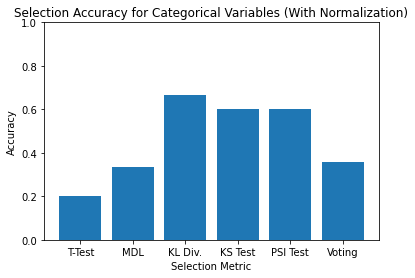

In [ ]:
accs = [TT_corr_cat, MDL_corr_cat, KL_corr_cat, KS_corr_cat, PSI_corr_cat, Vote_corr_cat]
types = ['T-Test', 'MDL', 'KL Div.', 'KS Test', 'PSI Test', 'Voting']

plt.figure()
plt.bar(types, accs)
plt.xlabel('Selection Metric')
plt.ylabel('Accuracy')
plt.title('Selection Accuracy for Categorical Variables (With Normalization)')
plt.ylim(0, 1)


(0.0, 1.0)

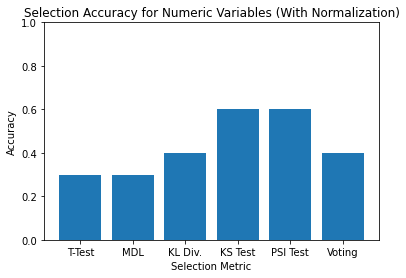

In [ ]:
accs = [TT_corr_num, MDL_corr_num, KL_corr_num, KS_corr_num, PSI_corr_num, Vote_corr_num]
types = ['T-Test', 'MDL', 'KL Div.', 'KS Test', 'PSI Test', 'Voting']

plt.figure()
plt.bar(types, accs)
plt.xlabel('Selection Metric')
plt.ylabel('Accuracy')
plt.title('Selection Accuracy for Numeric Variables (With Normalization)')
plt.ylim(0, 1)